# Tutorial 13: Classifiers as an Important Class of Predictive Models

#### Lecture and Tutorial Learning Goals:
After completing this week's lecture and tutorial work, you will be able to:

1. Give an example of a research question that requires a predictive model to predict classes on new observations.
2. Explain the trade-offs between model-based and non-model based approaches, and describe situations where each might be the preferred approach.
3. Write a computer script to perform model selection using ridge and LASSO regressions to fit a logistic regression useful for predictive modeling.
4. List model metrics that are suitable to evaluate predicted classes given by a predictive model with binary responses (e.g., Accuracy, Precision, Sensitivity, Specificity, Cohen's kappa).
5. Write a computer script to compute these model metrics. Interpret and communicate the results from that computer script.

In [1]:
# Run this cell before continuing.
library(tidyverse)
library(repr)
library(infer)
library(gridExtra)
library(caret)
library(pROC)
library(boot)
library(glmnet)
source("tests_tutorial_13.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var



Attaching package: ‘boot’


The following object is masked from ‘package:lattice’:

    melano

For this tutorial, we will keep working with the `breast_cancer` data set. 

In [2]:
# Run this cell before continuing

set.seed(20211130)

breast_cancer <- read_csv("data/breast_cancer.csv") %>%
    select(-c(
        mean_area, area_error, concavity_error, concave_points_error, worst_radius, worst_texture, worst_perimeter,
        worst_area, worst_smoothness, worst_compactness, worst_concavity, worst_concave_points, worst_symmetry,
        worst_fractal_dimension)) %>% 
    mutate(target = if_else(target == "malignant", 1, 0))

breast_cancer_train <- 
    breast_cancer %>% 
    slice_sample(prop = 0.70)

breast_cancer_test <- 
    breast_cancer %>% 
    anti_join(breast_cancer_train, by = "ID")

breast_cancer_train <- 
    breast_cancer_train %>% 
    select(-ID)

breast_cancer_test <- 
    breast_cancer_test %>% 
    select(-ID)

breast_cancer_logistic_model <- 
    glm(
        formula = target ~ .,
        data = breast_cancer_train,
        family = binomial)

ROC_full_log <- 
    roc(
        response = breast_cancer_train$target, 
        predictor = predict(breast_cancer_logistic_model, type = "response"))

Rows: 569 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): target
dbl (31): ID, mean_radius, mean_texture, mean_perimeter, mean_area, mean_smo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Setting levels: control = 0, case = 1

Setting direction: controls < cases



In the worksheet, you fitted the regular logistic regression to this data set. But, we can also use *shrinkage methods* in binary logistic regression. Shrinkage methods aim to improve your model by introducing some bias in exchange for a reduction in the model's variance. In general, we have the loss function that we are trying to minimize, and the shrinkage methods add a penalty term to it:

- *Ridge loss function* $ = Loss(\beta) + \lambda||\beta||_2$
    - For example, for linear regression we have $  L_\text{Ridge}(\beta)= \sum_{i=1}^N \left(y_i - \beta_0 - \sum_{j=1}^p\beta_jX_{ij}\right)^2 + \lambda\sum_{j=1}^p\beta_j^2$
    
    
- *Lasso loss function* $ = Loss(\beta) + \lambda||\beta||_1$
    - For example, for linear regression we have $ L_\text{Lasso}(\beta) = \sum_{i=1}^N \left(y_i - \beta_0 - \sum_{j=1}^p\beta_jX_{ij}\right)^2 + \lambda\sum_{j=1}^p|\beta_j|$

For the logistic regression we have:

$$L_{\text{Ridge}}(\beta_0, \beta_1, \dots, \beta_{p-1}) = - \sum_{i = 1}^n  \Bigg\{ -\log \Bigg[ 1 + \exp \Bigg(\beta_0 + \sum_{j = 1}^{p -1}\beta_j x_{ij} \Bigg) \Bigg] + y_i \Bigg( \beta_0 + \sum_{j = 1}^{p -1}\beta_j x_{ij} \Bigg) \Bigg\} + \lambda \sum_{j = 1}^{p - 1} \beta_j^2,$$

- *Note: don't worry about these functions; we are adding them here just FYI.*

The package `glmnet` takes variables only as matrices. Therefore, we need to prepare our data before fitting the regularized models using `glmnet`.

**Question 1.0**
<br>{points: 1}

To prepare the model matrix for `glmnet`, we will use the `model.matrix` function, which receives two arguments:

- `object`: which is the formula of your model.
- `data`: which is the data you want to use.

The `model.matrix` function adds a column named `(Intercept)` filled with ones. We do not need this column, so let's remove it. We will also need the response variable to be in a matrix format, so let's create this now. 

Save the model matrix in an object named `model_matrix_X_train` and the response matrix in an object named `matrix_Y_train`. 

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [3]:
# model_matrix_X_train <- 
#     ...

# matrix_Y_train <- 
#     as.matrix(..., ncol = 1)

# your code here
model_matrix_X_train <- 
    model.matrix(object = target ~ . -1, data = breast_cancer_train)

matrix_Y_train <- 
    as.matrix(breast_cancer_train$target, ncol = 1)

In [4]:
test_1.0()

Test passed 🥇
Test passed 🎊
Test passed 😀
Test passed 😸
Test passed 🎉
Test passed 🥳
Test passed 😸
Test passed 🌈
[1] "Success!"


## Ridge Regression

**Question 1.1**
<br>{points: 1}

Once we have our training data prepared in `model_matrix_X_train` and `matrix_Y_train`, let us find the value of $\lambda$ in $L_{\text{Ridge}}(\beta_0, \beta_1, \dots, \beta_{p})$ that provides the **largest** AUC using **cross-validation** (CV). 

The function `cv.glmnet()` runs a cross-validation for any estimator in the `glmnet` family. The data is divided into $k$ folds. An AUC is computed in one fold left out using a model that is trained in the remaining folds. This calculation is repeated for all folds so you get $k$ AUC values for each $\lambda$ in the grid.

Recall that ridge regression is defined when `alpha` is equal to zero. 

In this questions, use `auc` as the `type.measure` to measure prediction performance, and set the number of folds `nfolds` to 10. 

Note that the other arguments are the same as we used before to fit a Ridge linear regression model.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [5]:
set.seed(1234) # do not change this!

# breast_cancer_cv_lambda_ridge <- 
#   cv.glmnet(
#        x = ..., 
#        y = ...,
#        alpha = ...,
#        family = ...,
#        type.measure = ...,
#        nfolds = ...)

# breast_cancer_cv_lambda_ridge 

# your code here
breast_cancer_cv_lambda_ridge <- 
  cv.glmnet(
       x = model_matrix_X_train, 
       y = matrix_Y_train,
       alpha = 0,
       family = "binomial",
       type.measure = "auc",
       nfolds = 10)

breast_cancer_cv_lambda_ridge 


Call:  cv.glmnet(x = model_matrix_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 10, alpha = 0, family = "binomial") 

Measure: AUC 

    Lambda Index Measure       SE Nonzero
min 0.0498    97  0.9889 0.003856      16
1se 0.3859    75  0.9851 0.005613      16

In [6]:
test_1.1()

Test passed 😀
Test passed 😀
Test passed 😀
Test passed 🌈
[1] "Success!"


**Question 1.2**

The object `breast_cancer_cv_lambda_ridge` from `cv.glmnet()` is a list of different elements. We find the optimum value for $\lambda$ in ridge regression with this object. We can use `breast_cancer_cv_lambda_ridge` via `plot()` to visualize the resulting cross-validation AUCs for each value of $\lambda$. Recall that there are $k$ AUC values for each $\lambda$.

The resulting plot will indicate the average AUC (red dot) and error bars (in grey) on the $y$-axis along with the $\lambda$ sequence on the $x$-axis in log-scale. 


The top $x$-axis will indicate the number of inputs whose estimated coefficients are different from zero by each value of $\lambda$. Note that for Ridge we will always see the to on this top $x$-axis since the Ridge penalty never shrinks estimates to zero. 

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

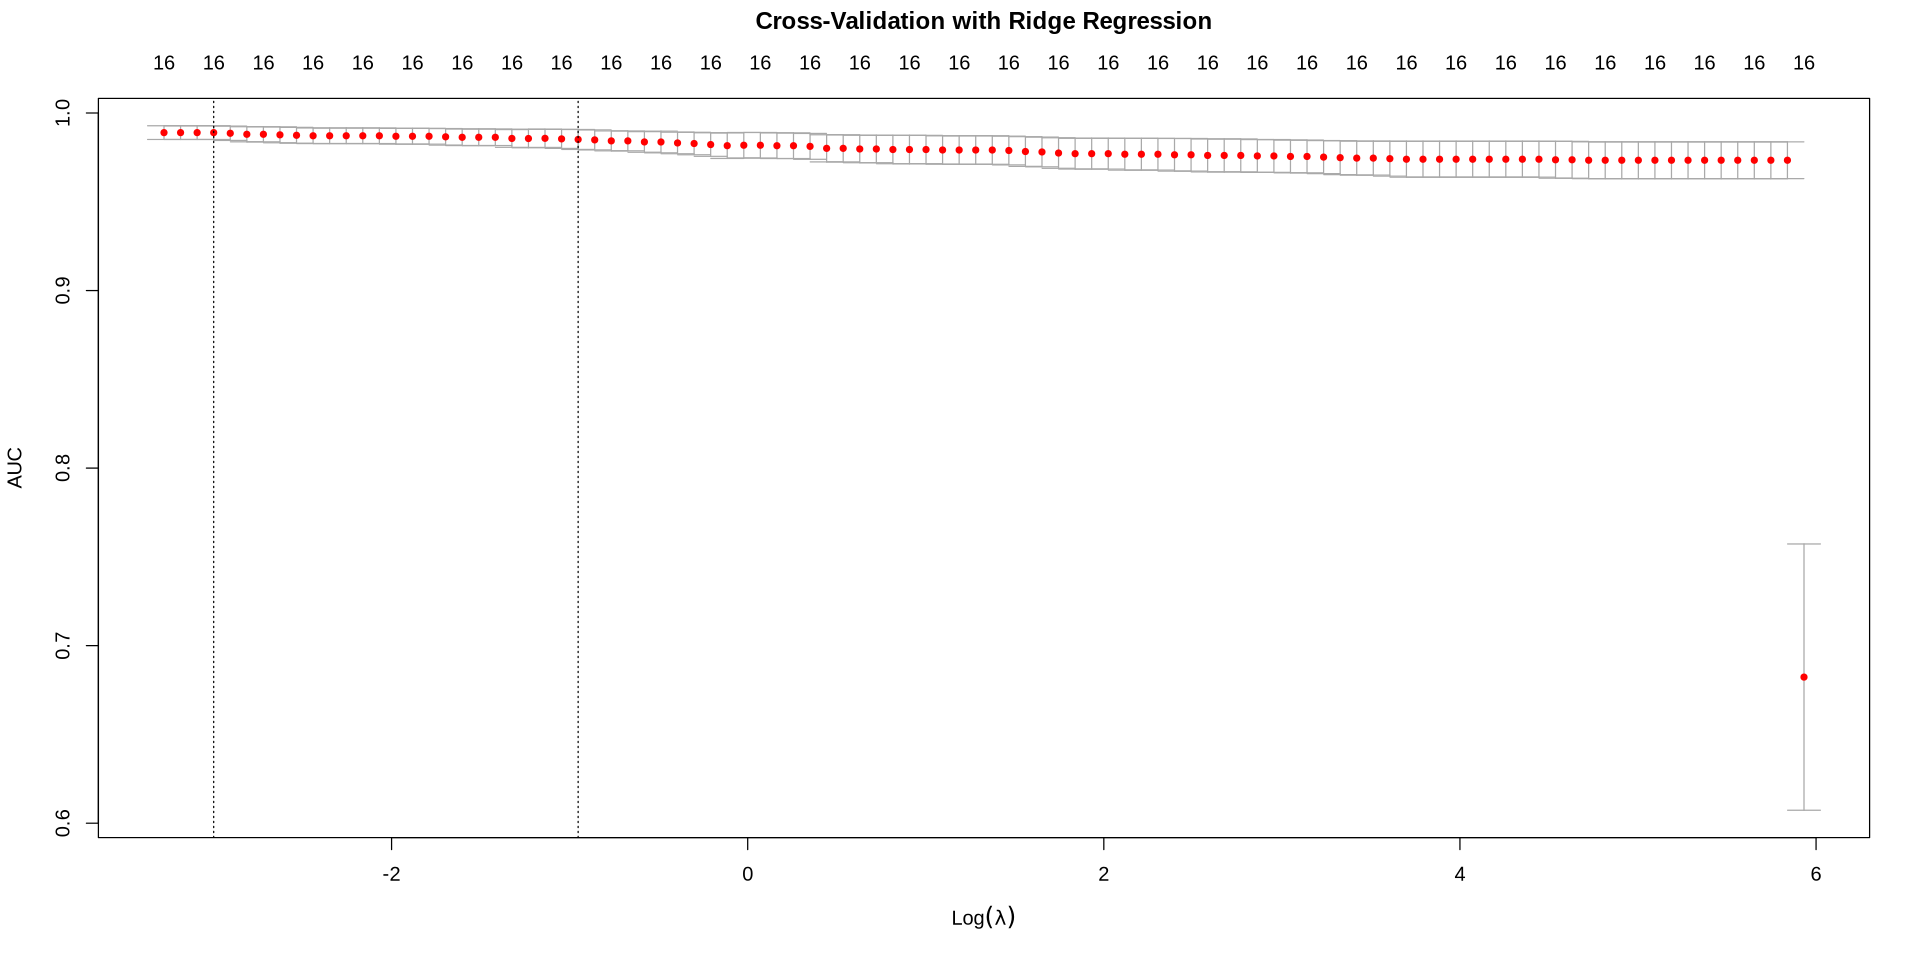

In [7]:
# Adjust these numbers so the plot looks good in your computer.
options(repr.plot.width = 16, repr.plot.height = 8) 

# plot(..., 
#      main = "Cross-Validation with Ridge Regression\n\n")

# your code here
plot(breast_cancer_cv_lambda_ridge, 
     main = "Cross-Validation with Ridge Regression\n\n")

**Question 1.3**
<br>{points: 1}

The plot in **Question 1.2** shows two vertical dotted lines. *Given an `object` coming from `cv.glmnet()`*, these lines correspond to two values of $\lambda$:

- $\hat{\lambda}_{\text{min}}$ which provides the maximum average AUC out of the whole sequence for $\lambda$. We can obtain it with `object$lambda.min`.


- $\hat{\lambda}_{\text{1SE}}$ the highest $\lambda$ for which average AUC within one standard error of the maximum. We can obtain it with `object$lambda.1se`.


Using `breast_cancer_cv_lambda_ridge`, obtain $\hat{\lambda}_{\text{min}}$ and assign it to the variable `breast_cancer_lambda_max_AUC_ridge`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [8]:
# breast_cancer_lambda_max_AUC_ridge <- round(..., 4)


# your code here
breast_cancer_lambda_max_AUC_ridge <- round(breast_cancer_cv_lambda_ridge$lambda.min, 4)

breast_cancer_lambda_max_AUC_ridge

[1] 0.0498

In [9]:
test_1.3()

Test passed 😸
Test passed 🎊
Test passed 😀
[1] "Success!"


**Question 1.4**

Visualize the estimated regression coefficients all over the $\lambda$ range. 

Use `breast_cancer_cv_lambda_ridge$glmnet.fit` along with a second argument called `"lambda"` within the function `plot()`. 

You will see that the estimated coefficients shrink towards zero as the value of $\lambda$ increases. Moreover, use the `abline()` function to indicate `breast_cancer_lambda_max_AUC_ridge` as a vertical dashed line in red **on the natural logarithm scale**.


*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

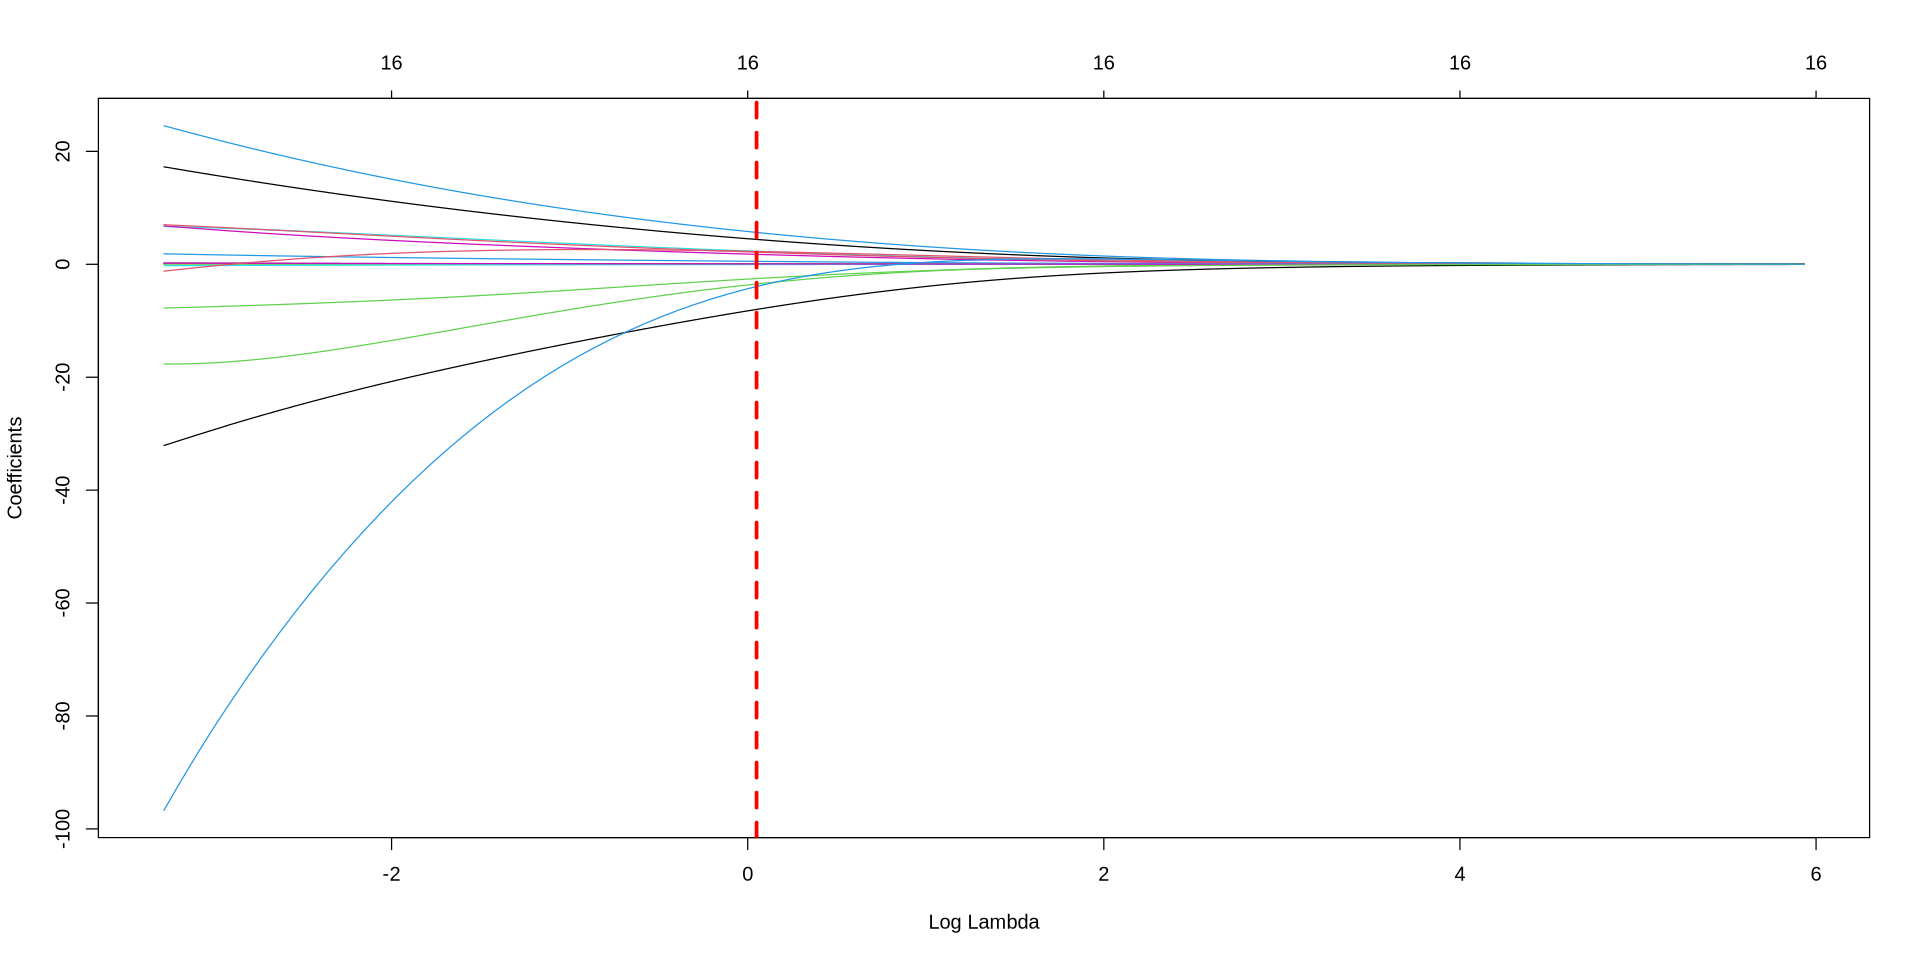

In [10]:
# ...(..., "lambda")
# ...(v = ..., col = "red", lwd = 3, lty = 2)

# your code here
plot(breast_cancer_cv_lambda_ridge$glmnet.fit, "lambda")
abline(v = breast_cancer_lambda_max_AUC_ridge, col = "red", lwd = 3, lty = 2)

**Question 1.5**
<br>{points: 1}

Once we have the optimum value for $\lambda$, let us fit the ridge regression model we will compare versus `breast_cancer_logistic_model` (from the worksheet). We will use the function `glmnet()` along with `model_matrix_X_train` and `matrix_Y_train`. Extract the fit for a `lambda` value equal to `breast_cancer_lambda_max_AUC_ridge`.

Call the resulting estimated model `breast_cancer_ridge_max_AUC`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [11]:
set.seed(1234) # DO NOT CHANGE!

# breast_cancer_ridge_max_AUC <- 
#   glmnet(
#   x = ..., y = ...,
#   alpha = ...,
#   family = ...,
#   lambda = ...
# )

#coef(breast_cancer_ridge_max_AUC)

# your code here
breast_cancer_ridge_max_AUC <- 
  glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 0,
  family = "binomial",
  lambda = breast_cancer_lambda_max_AUC_ridge
)

coef(breast_cancer_ridge_max_AUC)

17 x 1 sparse Matrix of class "dgCMatrix"
                                  s0
(Intercept)             -12.25233519
mean_radius               0.16861306
mean_texture              0.12734121
mean_perimeter            0.02439711
mean_smoothness          22.21254475
mean_compactness          6.44858777
mean_concavity            6.12385608
mean_concave_points      15.80733667
mean_symmetry             6.59686627
mean_fractal_dimension  -17.46888219
radius_error              1.68465834
texture_error            -0.21767361
perimeter_error           0.18855005
smoothness_error        -29.32174839
compactness_error        -0.29650818
symmetry_error           -7.50992397
fractal_dimension_error -82.12399536

In [12]:
test_1.5()

Test passed 🌈
Test passed 🥳
Test passed 🎉
Test passed 🥇
[1] "Success!"


**CV-AUC for a Logistic Regression (without penalization)**

In `worksheet_13`, we've computed the CV missclassification error for a classical (non-penalized) logistic regression. Let's compute here the CV AUC to compare it with that of  penalized models. Read the given code if you want to learn more about CV!

*Run the following cell.*

In [13]:
set.seed(1234)
num.folds <- 10

folds <- createFolds(breast_cancer_train$target, k=num.folds)

regr.cv <- NULL
for (fold in 1:num.folds) {
train.idx <- setdiff(1:nrow(breast_cancer_train), folds[[fold]])
regr.cv[[fold]] <- glm(target ~ ., data=breast_cancer_train, subset=train.idx,
                       family="binomial")
    }

pred.cv <- NULL
auc.cv <- numeric(num.folds) 

for (fold in 1:num.folds) {
test.idx <- folds[[fold]]
pred.cv[[fold]] <- data.frame(obs=breast_cancer_train$target[test.idx],
pred=predict(regr.cv[[fold]], newdata=breast_cancer_train, type="response")[test.idx])
auc.cv[fold] <- roc(obs ~ pred, data=pred.cv[[fold]])$auc
    }

breast_cancer_cv_ordinary <- round(mean(auc.cv),7)

cat("Cross-validation AUC for the ordinary logistic model:", 
breast_cancer_cv_ordinary)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Se

Cross-validation AUC for the ordinary logistic model: 0.9747854

**Question 1.6**
<br>{points: 1}

To help us keep track of the AUC for different models, let's create a data frame with the AUC computed by CV for each of our models: (1) ridge logistic regression and (2) ordinary logistic regression (from the worksheet). 

Note that all the average AUC values from the CV are stored in an object called `cvm` from  `cv.glmnet`. 

Store the ridge and ordinary models' cross-validation AUCs in a tibble called `breast_cancer_AUC_models` with two columns:

- `model`: The regression model from which we will obtain the prediction accuracy. This will be a string vector with elements: `"ordinary"` and `"ridge"`.
- `auc`: A numerical vector with AUC corresponding to each model.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [14]:
# breast_cancer_AUC_models <- 
#     tibble(
#         model = ...,
#         auc = ...)

# breast_cancer_AUC_models

# your code here
breast_cancer_AUC_models <- 
    tibble(
        model = c("ordinary", "ridge"),
        auc = c(breast_cancer_cv_ordinary, breast_cancer_cv_lambda_ridge$cvm[breast_cancer_cv_lambda_ridge$index[1]]))

breast_cancer_AUC_models

model,auc
<chr>,<dbl>
ordinary,0.9747854
ridge,0.9889454


In [15]:
test_1.6()

Test passed 😀
Test passed 😀
Test passed 😀
Test passed 🌈
[1] "Success!"


## LASSO Regression

**Question 1.7**
<br>{points: 1}

We already prepared our training data with `model_matrix_X_train` and `matrix_Y_train`. Now we need to find the value of $\lambda$ in $L_{\text{LASSO}}(\beta_0, \beta_1, \dots, \beta_{p-1})$ that provides the largest average AUC. 

Use the function `cv.glmnet()`. Remember LASSO regression is defined when `alpha` is equal to one.  Specify the proper accuracy `type.measure` and number of folds `nfolds` (use $k = 5$) along with the correct argument for `family`.

*Assign the function's output as `breast_cancer_cv_lambda_LASSO`.*

In [16]:
set.seed(1234) # do not change this!

# breast_cancer_cv_lambda_LASSO <- 
#   ...(
#   x = ..., y = ...,
#   alpha = ...,
#   family = ...,
#   type.measure = ...,
#   nfolds = ...)

# breast_cancer_cv_lambda_LASSO

# your code here
breast_cancer_cv_lambda_LASSO <- 
  cv.glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 1,
  family = "binomial",
  type.measure = "auc",
  nfolds = 5)

breast_cancer_cv_lambda_LASSO


Call:  cv.glmnet(x = model_matrix_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 5, alpha = 1, family = "binomial") 

Measure: AUC 

     Lambda Index Measure       SE Nonzero
min 0.01750    34  0.9876 0.004776       7
1se 0.06437    20  0.9831 0.007000       3

In [17]:
test_1.7()

Test passed 😀
Test passed 😀
Test passed 😀
Test passed 🌈
[1] "Success!"


The object `breast_cancer_cv_lambda_LASSO` is also a list of different elements we will use to obtain the LASSO regression with an optimum value for $\lambda$. As before, we can use the function `plot()` to visualize the cross-validation AUC values for each value of the $\lambda$ sequence.

This time, for LASSO logistic regression, we will see different values on this top $x$-axis since the model will shrink some coefficients to exactly zero. 

The following plot compares the Ridge and the LASSO path to select lambda values. You can see that for LASSO, but not for Ridge, all estimates will become zero for large $\lambda$ values.

*Run the cell below.*

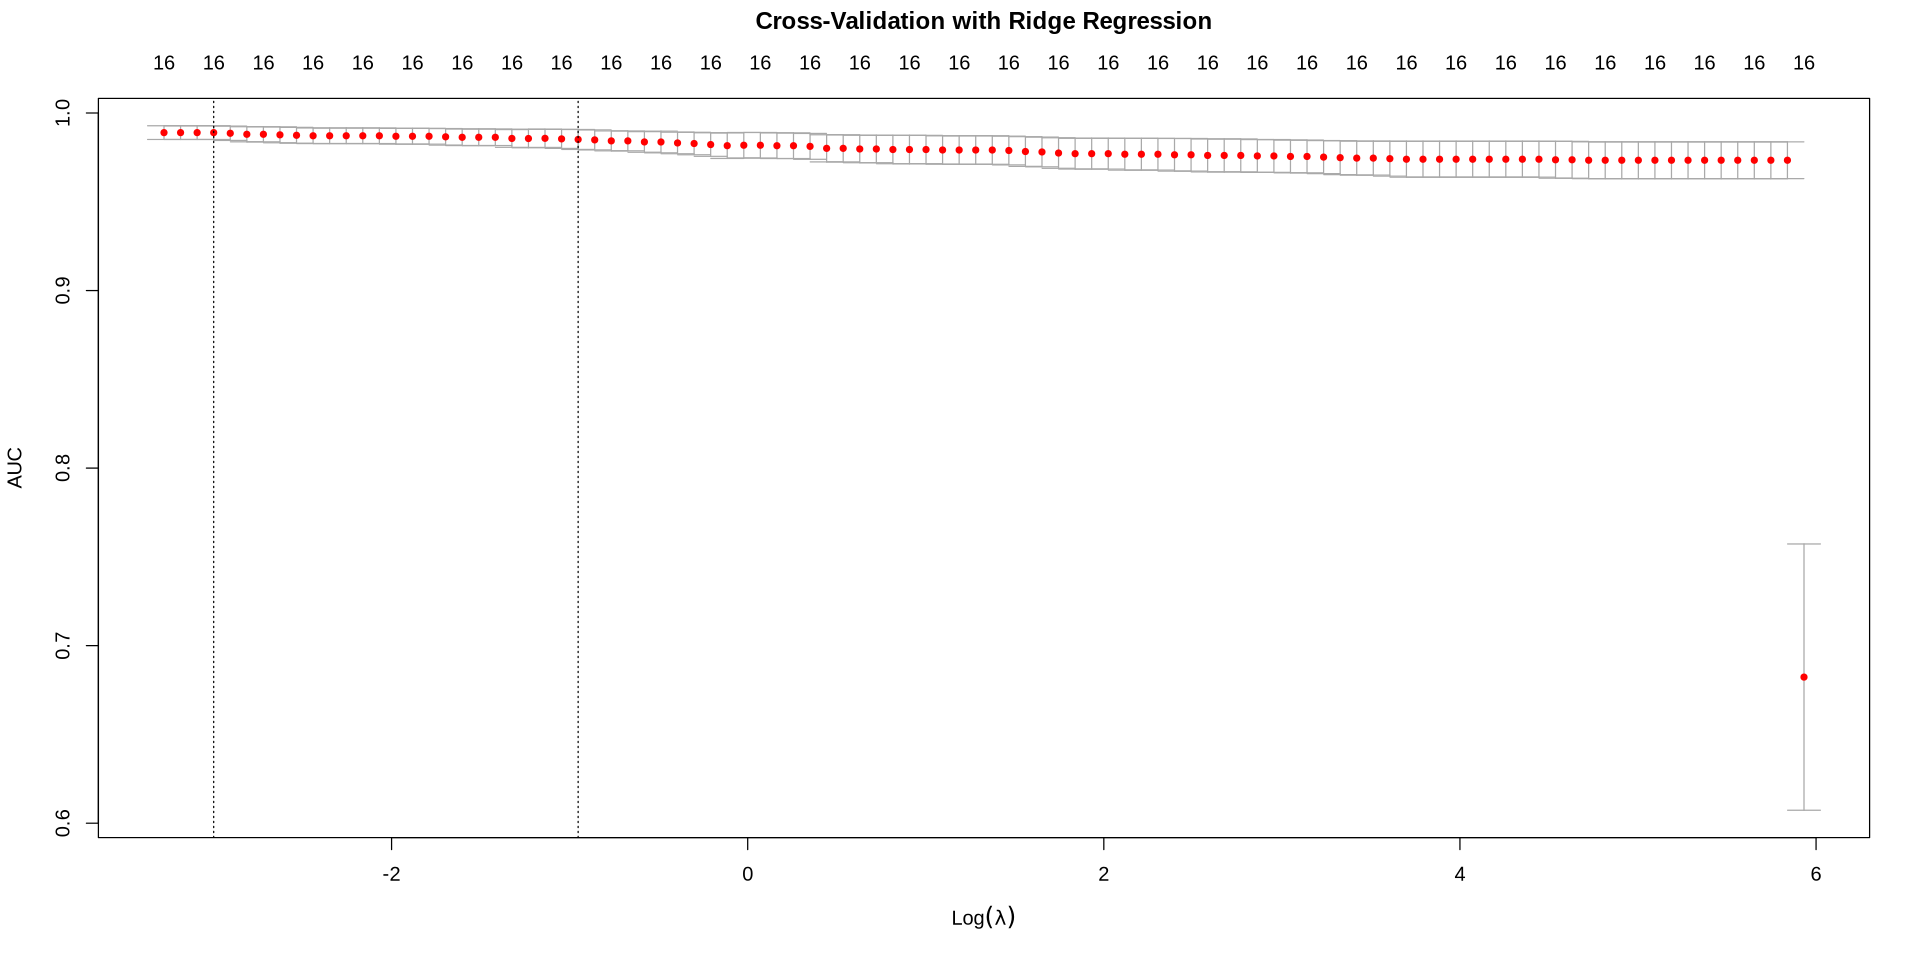

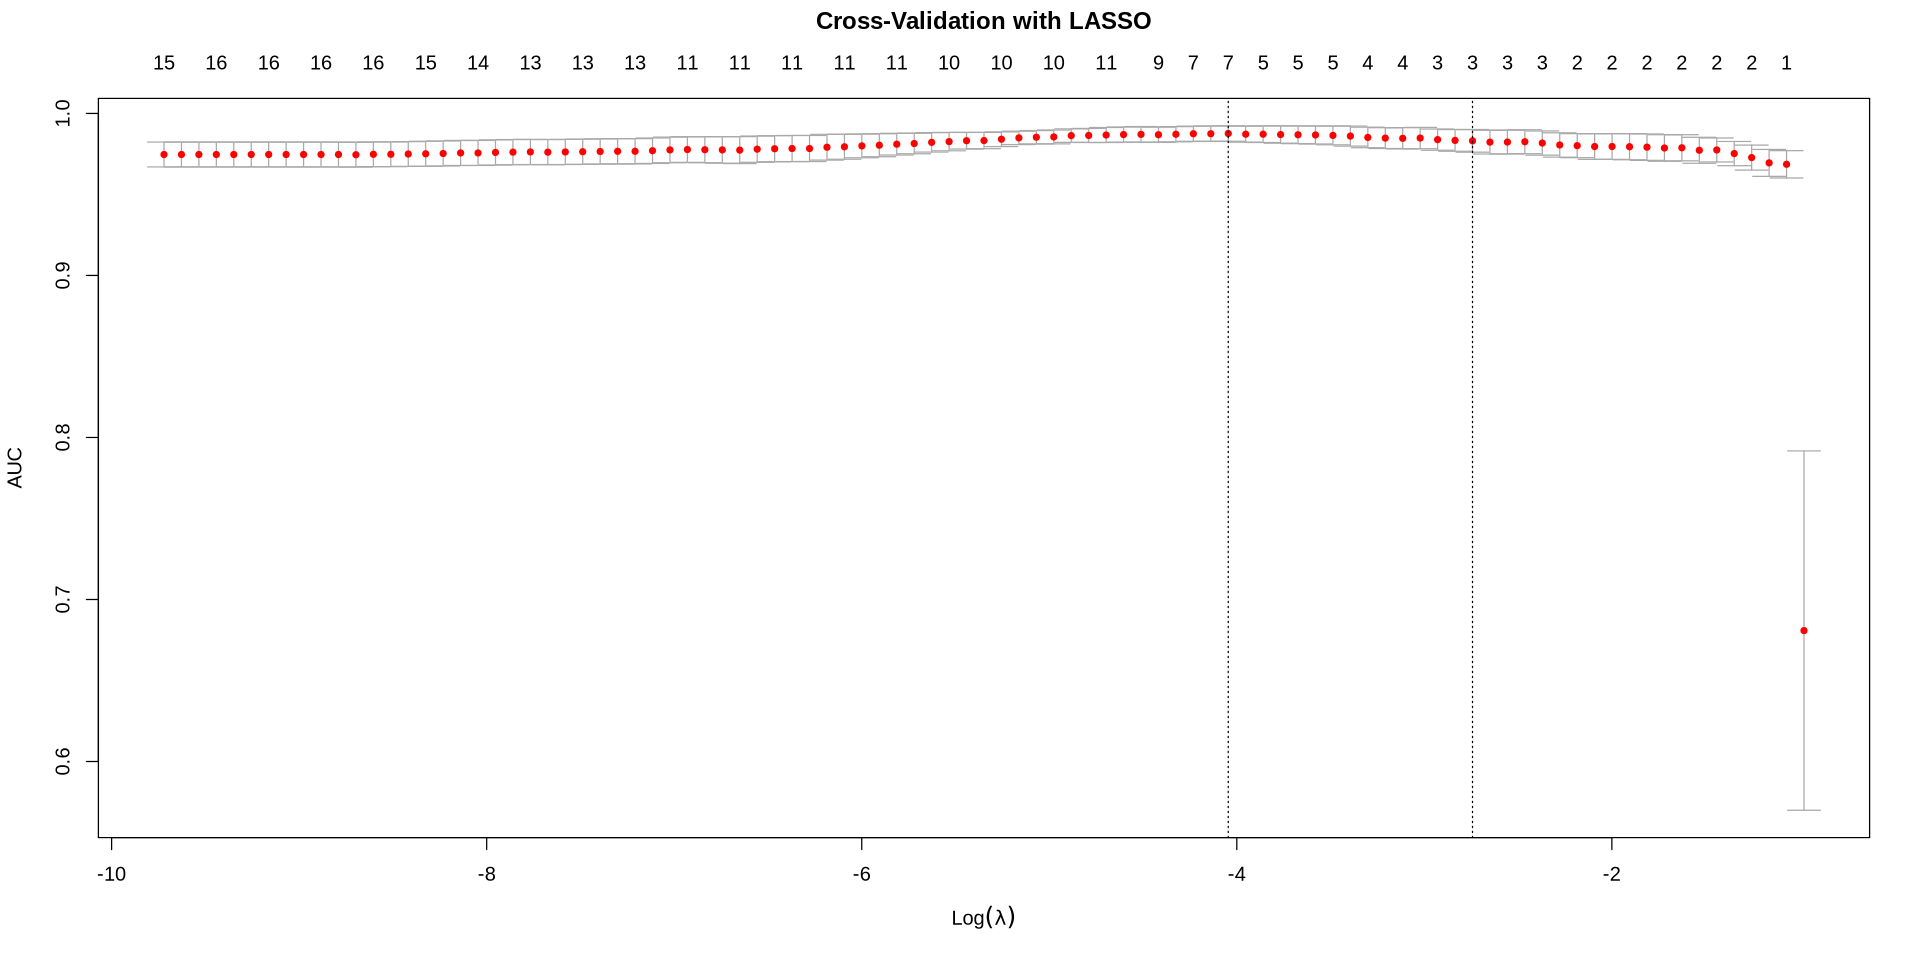

In [18]:
options(repr.plot.width = 16, repr.plot.height = 8) # Adjust these numbers so the plot looks good in your desktop.

plot(breast_cancer_cv_lambda_ridge, main = "Cross-Validation with Ridge Regression\n\n")

plot(breast_cancer_cv_lambda_LASSO, main = "Cross-Validation with LASSO\n\n")

**Question 1.8**
<br>{points: 1}

The plot of the output coming from `cv.glmnet()` shows two vertical dotted lines. These lines correspond to two values of $\lambda$:

- $\hat{\lambda}_{\text{min}}$ which provides the maximum average AUC out of the whole sequence for $\lambda$. We can obtain it with `object$lambda.min`.


- $\hat{\lambda}_{\text{1SE}}$ is the highest $\lambda$ for which the model has an average AUC within one standard error of the maximum. We can obtain it with `object$lambda.1se`.


In some cases, $\hat{\lambda}_{\text{1SE}}$ is preferable because we can select a considerably simpler model (three variables instead of seven) without having a significant reduction of the AUC. 

Using `breast_cancer_cv_lambda_LASSO`, obtain $\hat{\lambda}_{\text{1se}}$ and assign it to the variable `breast_cancer_lambda_1se_AUC_LASSO`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [19]:
# breast_cancer_lambda_1se_AUC_LASSO <- round(..., 4)

# your code here
breast_cancer_lambda_1se_AUC_LASSO <- round(breast_cancer_cv_lambda_LASSO$lambda.1se, 4)

breast_cancer_lambda_1se_AUC_LASSO

[1] 0.0644

In [20]:
test_1.8()

Test passed 😸
Test passed 🎊
Test passed 😀
[1] "Success!"


**Question 1.9**
<br>{points: 1}

Let's compare the LASSO logistic model fit at the `lambda.1se` with `breast_cancer_log_model` and `breast_cancer_ridge_max_AUC`. 

We will use the function `glmnet()` along with `breast_cancer_X_train` and `breast_cancer_Y_train`. Extract the estimated model for `lambda` equal to `breast_cancer_lambda_1se_AUC_LASSO`. Call the output `breast_cancer_LASSO_1se_AUC`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [21]:
set.seed(1234) # do not change this!

# breast_cancer_LASSO_1se_AUC <- ...(
#   x = ..., y = ...,
#   alpha = ...,
#   family = ...,
#   lambda = ...
# )

# breast_cancer_LASSO_1se_AUC

# your code here
breast_cancer_LASSO_1se_AUC <- glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 1,
  family = "binomial",
  lambda = breast_cancer_lambda_1se_AUC_LASSO
)

coef(breast_cancer_LASSO_1se_AUC)

17 x 1 sparse Matrix of class "dgCMatrix"
                                 s0
(Intercept)             -6.37036359
mean_radius              .         
mean_texture             0.04729990
mean_perimeter           0.03225831
mean_smoothness          .         
mean_compactness         .         
mean_concavity           .         
mean_concave_points     36.84985757
mean_symmetry            .         
mean_fractal_dimension   .         
radius_error             .         
texture_error            .         
perimeter_error          .         
smoothness_error         .         
compactness_error        .         
symmetry_error           .         
fractal_dimension_error  .         

In [22]:
test_1.9()

Test passed 🌈
Test passed 🥳
Test passed 🎉
Test passed 🥇
[1] "Success!"


**Question 1.10**
<br>{points: 1}


Based on the results above, where those estimated regression coefficients equal to zero are shown as `.`, what input variables are selected in `breast_cancer_LASSO_1se_AUC`?

**A.** `mean_radius`.

**B.** `mean_texture`.

**C.** `mean_perimeter`.

**D.** `mean_smoothness`.

**E.** `mean_compactness`.

**F.** `mean_concavity`.

**G.** `mean_concave_points`.

**H.** `mean_symmetry`.

**I.** `mean_fractal_dimension`.

**J.** `radius_error`.

**K.** `texture_error`.

**L.** `perimeter_error`.

**M.** `smoothness_error`.

**N.** `compactness_error`.

**O.** `symmetry_error`.

**P.** `fractal_dimension_error`.

*Assign your answers to the object `answer1.12`. Your answers have to be included in a single string indicating the correct options **in alphabetical order** and surrounded by quotes.*

In [23]:
# answer1.10 <- 

# your code here
answer1.10 <- "BCG"

In [24]:
test_1.10()

Test passed 🌈
Test passed 🎊
Test passed 😀
[1] "Success!"


**Question 1.11**
<br>{points: 1}

Let's add the Lasso Logistic Regression row to our `breast_cancer_AUC_models` tibble. 

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [25]:
# breast_cancer_AUC_models <- 
#     breast_cancer_AUC_models %>% 
#     add_row(model = ..., 
#             auc = ...)

# your code here
breast_cancer_AUC_models <- 
    breast_cancer_AUC_models %>% 
    add_row(model = "Lasso Logistic Regression", 
            auc = breast_cancer_cv_lambda_LASSO$cvm[20])

breast_cancer_AUC_models

model,auc
<chr>,<dbl>
ordinary,0.9747854
ridge,0.9889454
Lasso Logistic Regression,0.9830725


In [26]:
test_1.11()

Test passed 🥇
Test passed 🎉
Test passed 🌈
Test passed 🥳
Test passed 🎊
[1] "Success!"


Great job! You can now choose a model that you expect will have a good prediction performance based on the CV results, without looking at the test set!! 

We can see that the ridge model is slightly better, although we used the $\lambda_{\min}$ for ridge and $\lambda_{1se}$ for lasso. On the other hand, the model selected by LASSO is considerably simpler since it uses only three of the variables while keeping similar performance. 

After choosing the model, you can apply the chosen model to the test set to estimate the model's performance. 

**Question 1.12**
<br>{points: 1}

Suppose you chose the LASSO model. Use the model to predict the `target` variable on the **test** set (`breast_cancer_test`). Then, use the `roc` function to obtain the ROC curve in the test set. Save the result in an object named ROC_LASSO. 


*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [27]:
# model_matrix_X_test <- 
#     ...(object = ...,
#                  data = ....)[, -1]

# ROC_lasso <- 
#     roc(
#         response = ...,
#         predictor = predict(...,
#                      newx = ...)[,"s0"] ) 

# your code here
model_matrix_X_test <- 
    model.matrix(object = target ~ .,
                 data = breast_cancer_test)[, -1]

ROC_lasso <- 
    roc(
        response = breast_cancer_test$target,
        predictor = predict(breast_cancer_LASSO_1se_AUC,
                     newx = model_matrix_X_test)[,"s0"] ) 

ROC_lasso

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = breast_cancer_test$target, predictor = predict(breast_cancer_LASSO_1se_AUC,     newx = model_matrix_X_test)[, "s0"])

Data: predict(breast_cancer_LASSO_1se_AUC, newx = model_matrix_X_test)[, "s0"] in 98 controls (breast_cancer_test$target 0) < 73 cases (breast_cancer_test$target 1).
Area under the curve: 0.9757

In [28]:
test_1.12()

Test passed 🎉
Test passed 🥳
[1] "Success!"


We can use the `plot` function to plot the `ROC_lasso` curve from the Lasso model in the test set. 

*Run the cell below.*

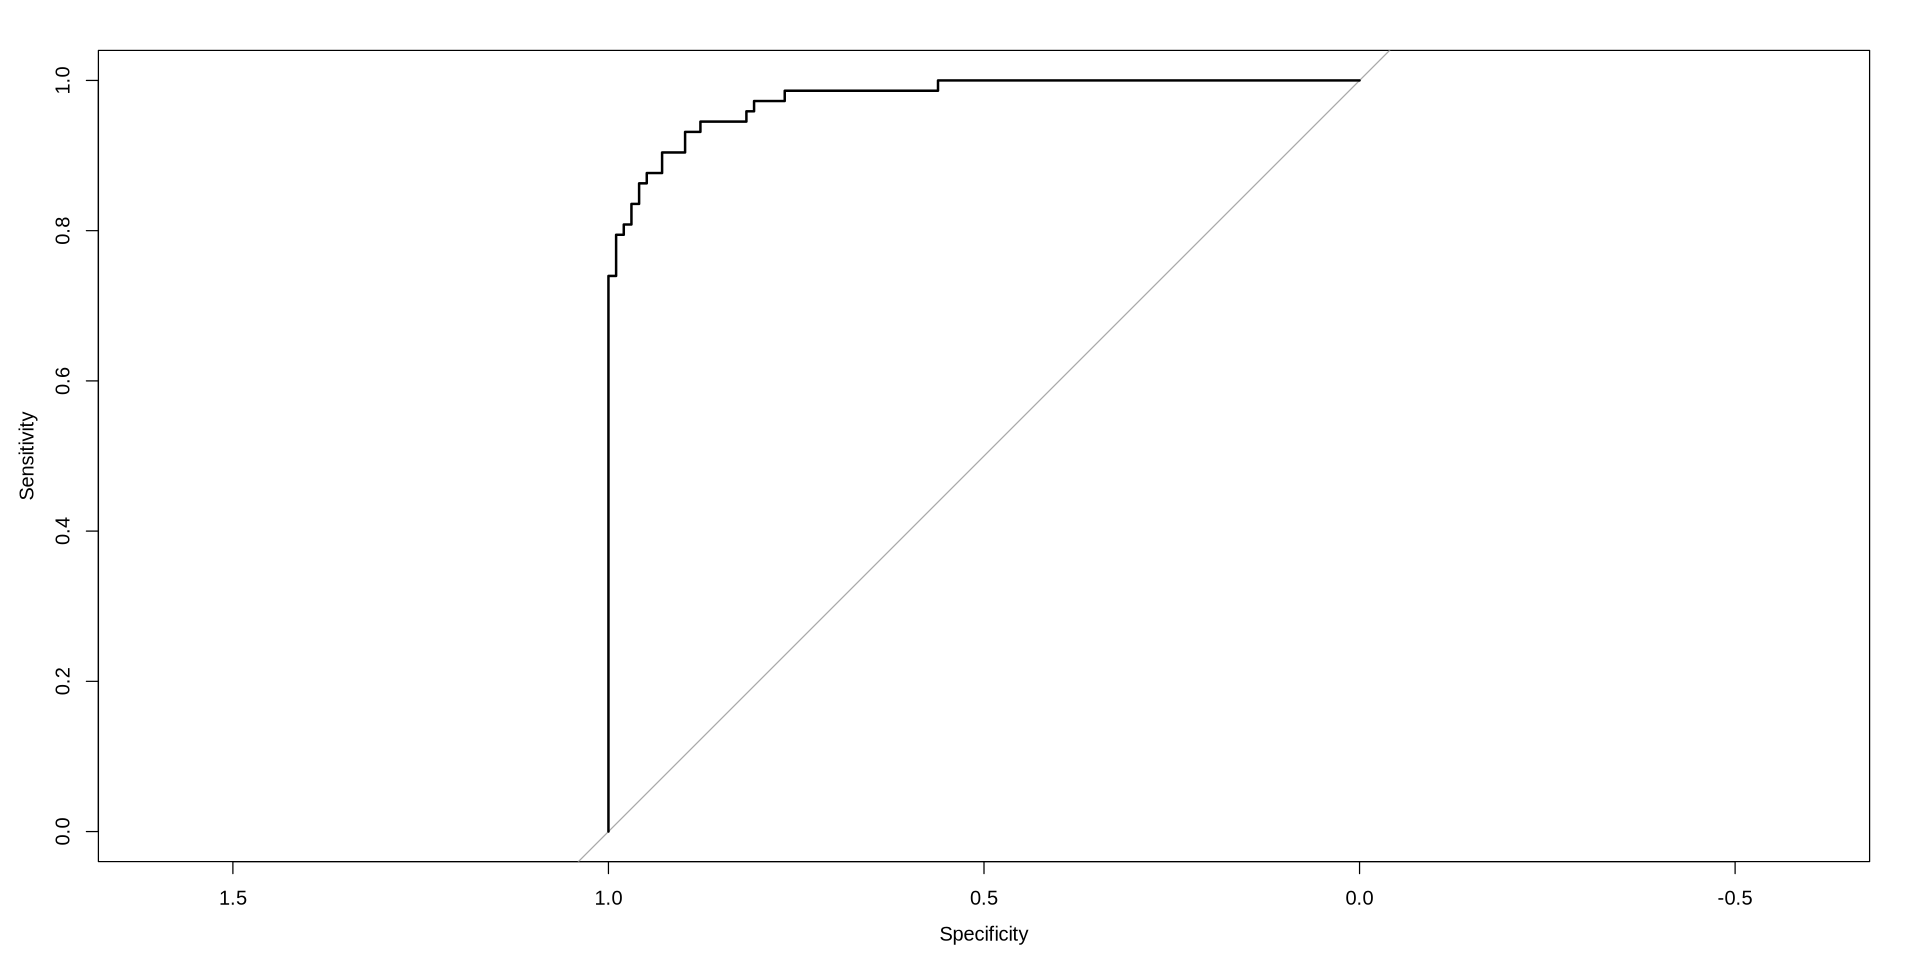

In [29]:
# your code here
plot(ROC_lasso)

Out of curiosity, let's check how the other two models perform in the test set. 

In [30]:
# Run this cell before continuing

ROC_ridge <- roc(
  response = breast_cancer_test$target,
  predictor = predict(breast_cancer_ridge_max_AUC,
                      newx = model_matrix_X_test )[,"s0"] )

ROC_ordinary <- roc(
  response = breast_cancer_test$target,
  predictor = predict(breast_cancer_logistic_model,
                      newdata = breast_cancer_test) )

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



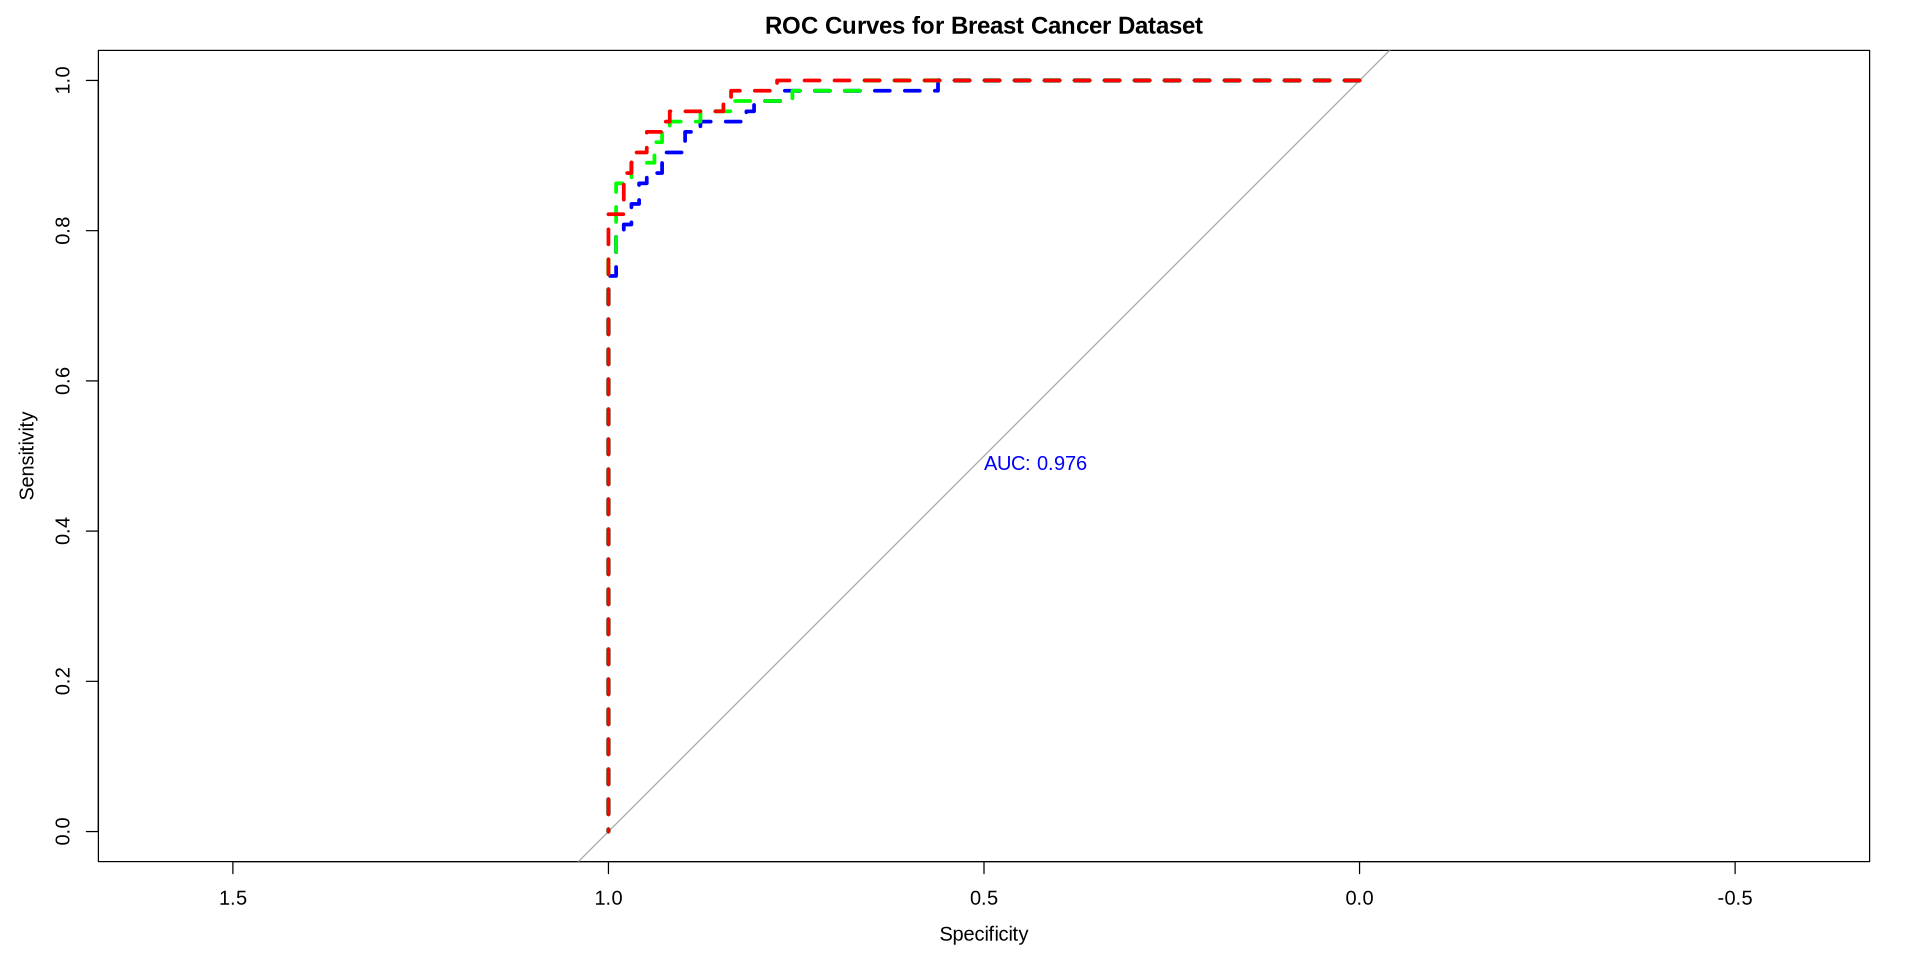

In [31]:
plot(ROC_lasso,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curves for Breast Cancer Dataset"
)

lines.roc(ROC_ridge, col = "green", lwd = 3, lty = 2, print.auc=TRUE)
lines.roc(ROC_ordinary, col = "red", lwd = 3, lty = 2)

From the ROC curve in the test set, the LASSO model performs worse (although reasonably close) to the other two models. So you might be tempted to switch models at this point. But changing models at this stage will bring optimization bias again, making the estimates of AUC obtained here to overestimate the AUC in (new) unseen data. 